In [1]:
!pip install tensorflow[and-cuda]

import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(42)
from sklearn.metrics import confusion_matrix
import keras
from keras.utils import to_categorical
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
import cv2
import random
import imgaug.augmenters as iaa
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import models, layers, optimizers
# Suppress warnings
warnings.filterwarnings("ignore")

  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of tensorflow[and-cuda] to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.6/412.6 MB 3.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 85.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.0/22.0 MB 73.3 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.9/24.9 MB 46.8 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 867.7/867.7 kB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 704.7/704.7 MB 2.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.8/98.8 MB 5.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 5.0 MB/s eta 0:00:00:00:01:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.2/125.2 MB 4.5 MB/s eta 0:00:00:00:0100:01

In [2]:
from keras.models import load_model

SIZE=64
# Define the known classes
classes = ['akiec', 'bcc', 'bkl', 'mel', 'nv', 'scc', 'unknown']

# Initialize the LabelEncoder
le = LabelEncoder()

# Fit the LabelEncoder on the known classes
le.fit(classes)
label_to_dx_mapping = {label: dx for label, dx in zip(le.transform(le.classes_), le.classes_)}
# Load the model
model = load_model('/kaggle/input/convnext/keras/convnext/2/convnext.keras')

Number of pictures for each class in test folder
dx
nv         6705
mel        1113
bkl        1099
bcc         514
akiec       327
unknown     257
Name: count, dtype: int64
label
4    6705
3    1113
2    1099
1     514
0     327
6     257
Name: count, dtype: int64


I0000 00:00:1714646209.569906     132 service.cc:145] XLA service 0x7ec80c0034b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1714646209.569958     132 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 10/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step

I0000 00:00:1714646212.942405     132 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step


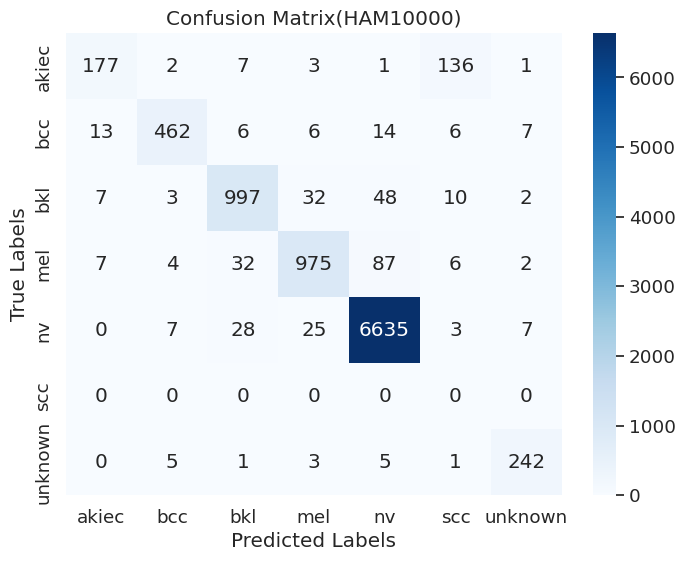


Multiclass Accuracy(HAM10000): 0.9473789316025961
HAM10000 Multiclass Classification Report():
              precision    recall  f1-score       support
akiec          0.867647  0.541284  0.666667    327.000000
bcc            0.956522  0.898833  0.926780    514.000000
bkl            0.930906  0.907188  0.918894   1099.000000
mel            0.933908  0.876011  0.904033   1113.000000
nv             0.977172  0.989560  0.983327   6705.000000
scc            0.000000  0.000000  0.000000      0.000000
unknown        0.927203  0.941634  0.934363    257.000000
accuracy       0.947379  0.947379  0.947379      0.947379
macro avg      0.799051  0.736359  0.762009  10015.000000
weighted avg   0.961369  0.947379  0.952946  10015.000000

Multiclass ROC AUC Score(HAM10000): 0.9237239649746379


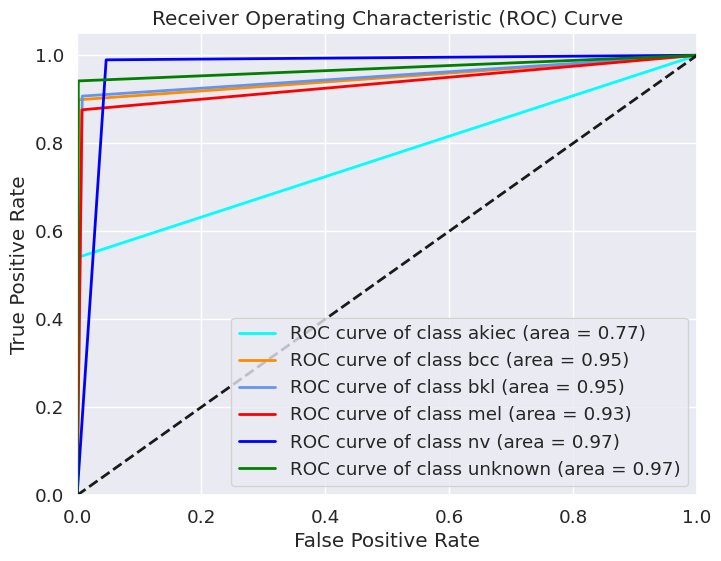

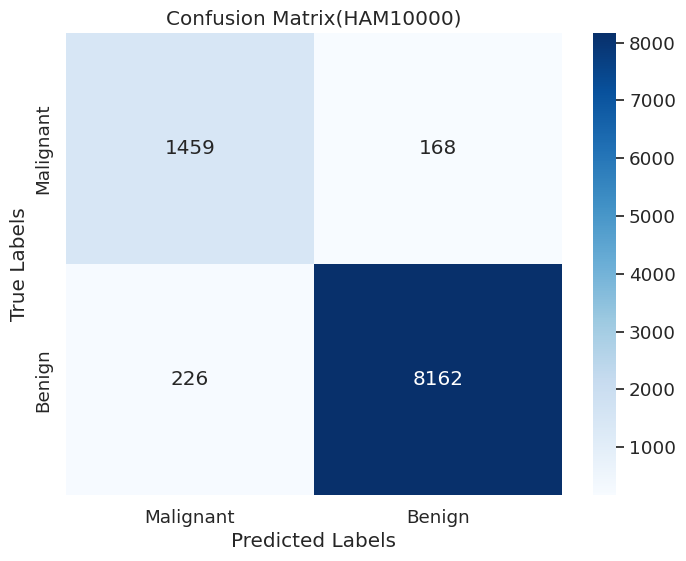


Binary Class Accuracy(HAM10000): 0.9606590114827759
HAM10000 Binary class Classification Report:
              precision    recall  f1-score       support
Malignant      0.865875  0.896742  0.881039   1627.000000
Benign         0.979832  0.973057  0.976433   8388.000000
accuracy       0.960659  0.960659  0.960659      0.960659
macro avg      0.922854  0.934900  0.928736  10015.000000
weighted avg   0.961319  0.960659  0.960935  10015.000000

Binary Class ROC AUC Score(HAM10000): 0.9348996092700111


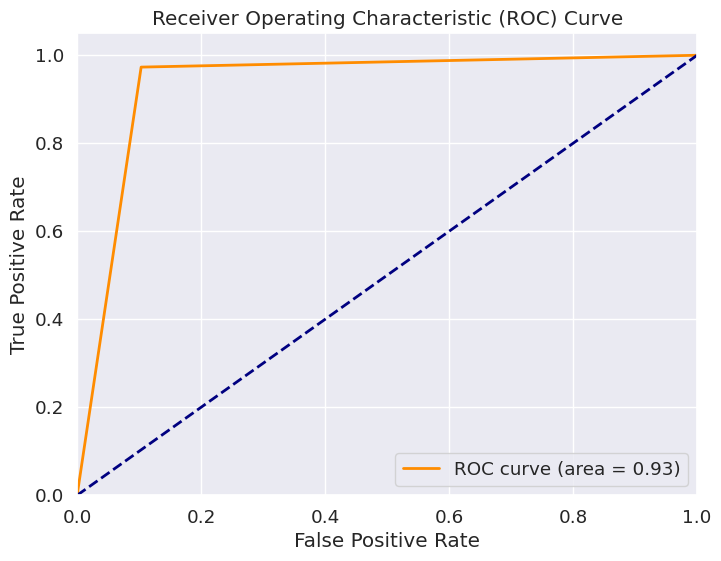

In [3]:
test_dir = '/kaggle/input/test-model-dataset/testing_model/HAM10000'
test_metadata = []
for disease in ['akiec', 'bcc', 'bkl', 'mel', 'nv', 'unknown']:
    test_images = os.listdir(os.path.join(test_dir, disease))
    test_metadata.extend([(os.path.join(test_dir, disease, image), disease) for image in test_images])
test_df1 = pd.DataFrame(test_metadata, columns=['image_id', 'dx'])
print("Number of pictures for each class in test folder")
print(test_df1['dx'].value_counts())
test_df1 = test_df1.sample(frac=1).reset_index(drop=True)

del test_metadata

# Now you can transform the labels in your dataframe
test_df1['label'] = le.transform(test_df1['dx'])
test_df1.drop('dx', axis=1, inplace=True)
print(test_df1['label'].value_counts())
images = []

# Iterate over the DataFrame
for idx, row in test_df1.iterrows():
    # Open, resize and convert the image to a numpy array
    image = np.asarray(Image.open(row['image_id']).resize((SIZE, SIZE)))
    # Append the image to the list
    images.append(image)
# Drop the 'image_id' column from the DataFrame
test_df1.drop('image_id', axis=1, inplace=True)

# Add the list of images as a new column in the DataFrame
test_df1['image'] = images

x_test = np.asarray(test_df1['image'].tolist())
# x_test = x_test/255.
Y=test_df1['label']
y_test = to_categorical(Y, num_classes=7)
y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Convert one-hot encoded actual classes to class labels
y_true_labels = np.argmax(y_test, axis=1)
# Convert class indices to class names for y_true and y_pred
y_true_labels_names = [label_to_dx_mapping[label] for label in y_true_labels]
y_pred_labels_names = [label_to_dx_mapping[label] for label in y_pred_labels]
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_labels_names, y_pred_labels_names)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(label_to_dx_mapping.values()),
            yticklabels=list(label_to_dx_mapping.values()))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix(HAM10000)')
plt.show()

# Calculate accuracy
accuracy = np.mean(y_pred_labels == y_true_labels)
print("\nMulticlass Accuracy(HAM10000):", accuracy)
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

report = classification_report(y_true_labels_names, y_pred_labels_names, output_dict=True)
report_df = pd.DataFrame(report).transpose()

lb = LabelBinarizer()

lb.fit(y_true_labels_names)
y_test_bin = lb.transform(y_true_labels_names)
y_pred_bin = lb.transform(y_pred_labels_names)

roc_auc = roc_auc_score(y_test_bin, y_pred_bin, multi_class='ovr')

print("HAM10000 Multiclass Classification Report():")
print(report_df)

print("\nMulticlass ROC AUC Score(HAM10000):", roc_auc)
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle

# Binarize the output
y_test_bin = label_binarize(y_true_labels, classes=[0, 1, 2, 3, 4, 6])
n_classes = 7

n_classes = y_test_bin.shape[1]  # This will now be 6

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):  # This will iterate over indices 0-5
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Plot all ROC curves

maping = ['akiec', 'bcc', 'bkl', 'mel', 'nv', 'unknown']
plt.figure(figsize=(8, 6))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'blue', 'green', 'brown'])
for i, color in zip([0, 1, 2, 3, 4, 5], colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(maping[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
# Convert y_pred to the new binary format
y_new = np.zeros((y_pred.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_new[:, 0] = y_pred[:, 1] + y_pred[:, 3] + y_pred[:, 5]
y_new[:, 1] = y_pred[:, 0] + y_pred[:, 2] + y_pred[:, 4] + y_pred[:, 6]

# Convert probabilities to class labels
y_pred_labels = np.argmax(y_new, axis=1)
# Convert one-hot encoded y_test to the new binary format
y_true_new = np.zeros((y_test.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_true_new[:, 0] = y_test[:, 1] + y_test[:, 3] + y_test[:, 5]
y_true_new[:, 1] = y_test[:, 0] + y_test[:, 2] + y_test[:, 4] + y_test[:, 6]

# Convert probabilities to class labels
y_true_labels = np.argmax(y_true_new, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Malignant', 'Benign'],
            yticklabels=['Malignant', 'Benign'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix(HAM10000)')
plt.show()

# Calculate accuracy
accuracy = np.mean(y_pred_labels == y_true_labels)
print("\nBinary Class Accuracy(HAM10000):", accuracy)
from sklearn.metrics import classification_report, roc_auc_score

# Calculate Precision, Recall, F1-score, and Support
report = classification_report(y_true_labels, y_pred_labels, target_names=['Malignant', 'Benign'], output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Calculate AUC score
roc_auc = roc_auc_score(y_true_labels, y_pred_labels)

print("HAM10000 Binary class Classification Report:")
print(report_df)

print("\nBinary Class ROC AUC Score(HAM10000):", roc_auc)
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_true_labels, y_pred_labels)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Number of pictures for each class in test folder
dx
unknown    27124
nv          5193
mel          584
bkl          225
Name: count, dtype: int64
label
6    27124
4     5193
3      584
2      225
Name: count, dtype: int64
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 24s 23ms/step


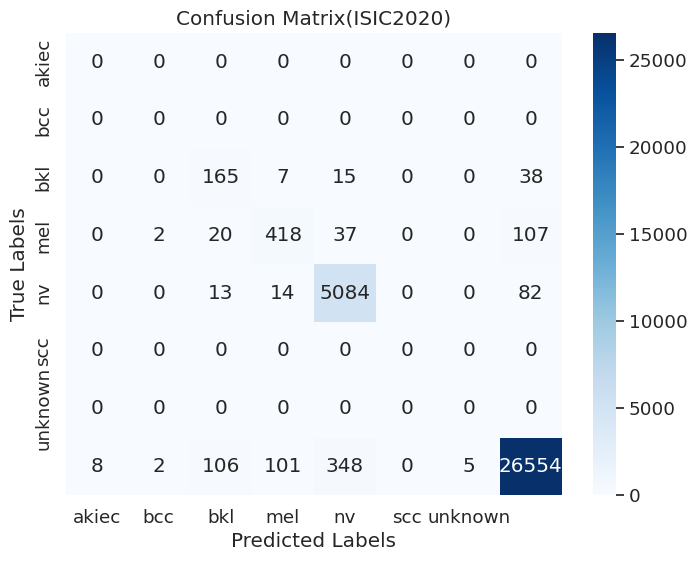


Multiclass Accuracy(ISIC2020): 0.9726800700356215
ISIC2020 Multiclass Classification Report():
              precision    recall  f1-score      support
akiec          0.000000  0.000000  0.000000      0.00000
bcc            0.000000  0.000000  0.000000      0.00000
bkl            0.542763  0.733333  0.623819    225.00000
mel            0.774074  0.715753  0.743772    584.00000
nv             0.927061  0.979010  0.952327   5193.00000
scc            0.000000  0.000000  0.000000      0.00000
unknown        0.991524  0.978985  0.985215  27124.00000
accuracy       0.972680  0.972680  0.972680      0.97268
macro avg      0.462203  0.486726  0.472162  33126.00000
weighted avg   0.974537  0.972680  0.973348  33126.00000

Multiclass ROC AUC Score(ISIC2020): 0.9183709826443478


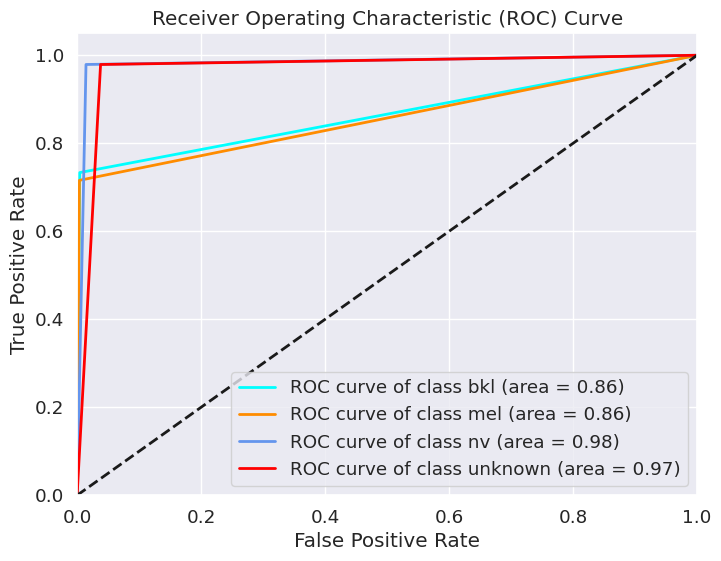

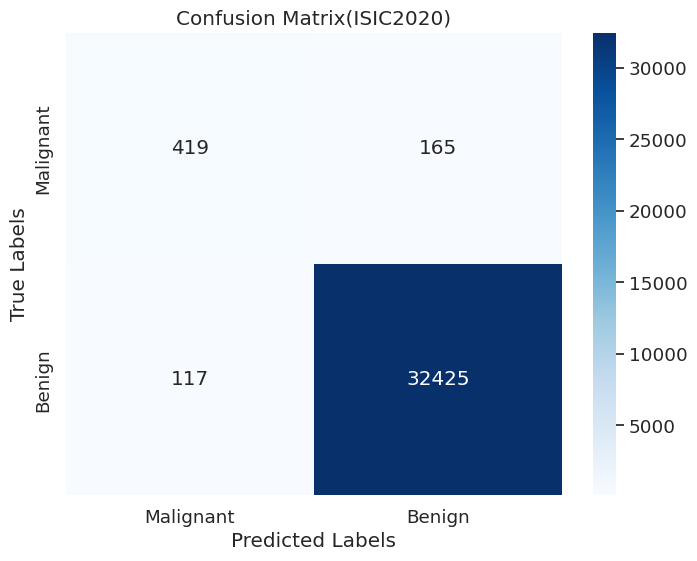


Binary Class Accuracy(ISIC2020): 0.9914870494475638
ISIC2020 Binary class Classification Report:
              precision    recall  f1-score       support
Malignant      0.781716  0.717466  0.748214    584.000000
Benign         0.994937  0.996405  0.995670  32542.000000
accuracy       0.991487  0.991487  0.991487      0.991487
macro avg      0.888327  0.856935  0.871942  33126.000000
weighted avg   0.991178  0.991487  0.991308  33126.000000

Binary Class ROC AUC Score(ISIC2020): 0.8569351998639483


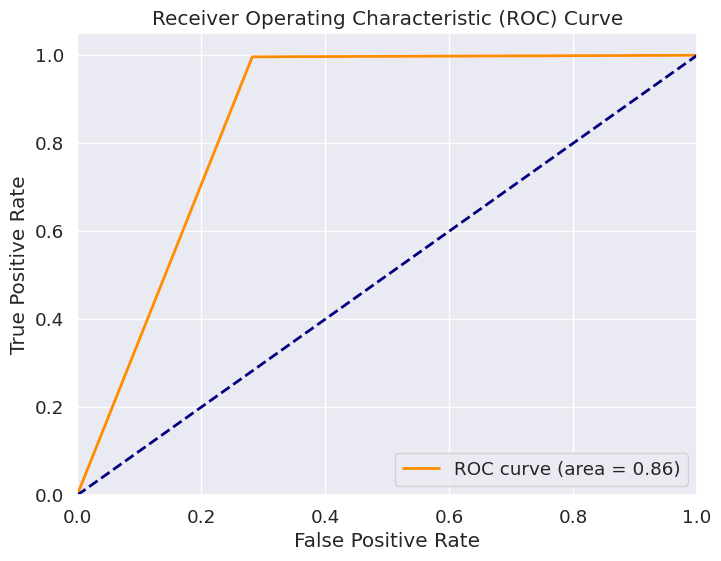

In [4]:
test_dir = '/kaggle/input/test-model-dataset/testing_model/2020'
test_metadata = []
for disease in ['bkl', 'mel', 'nv', 'unknown']:
    test_images = os.listdir(os.path.join(test_dir, disease))
    test_metadata.extend([(os.path.join(test_dir, disease, image), disease) for image in test_images])
test_df2 = pd.DataFrame(test_metadata, columns=['image_id', 'dx'])
print("Number of pictures for each class in test folder")
print(test_df2['dx'].value_counts())
test_df2 = test_df2.sample(frac=1).reset_index(drop=True)

del test_metadata

# Now you can transform the labels in your dataframe
test_df2['label'] = le.transform(test_df2['dx'])
test_df2.drop('dx', axis=1, inplace=True)
print(test_df2['label'].value_counts())
images = []

# Iterate over the DataFrame
for idx, row in test_df2.iterrows():
    # Open, resize and convert the image to a numpy array
    image = np.asarray(Image.open(row['image_id']).resize((SIZE, SIZE)))
    # Append the image to the list
    images.append(image)
# Drop the 'image_id' column from the DataFrame
test_df2.drop('image_id', axis=1, inplace=True)

# Add the list of images as a new column in the DataFrame
test_df2['image'] = images

x_test = np.asarray(test_df2['image'].tolist())
# x_test = x_test/255.
Y=test_df2['label']
y_test = to_categorical(Y, num_classes=7)
y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Convert one-hot encoded actual classes to class labels
y_true_labels = np.argmax(y_test, axis=1)
# Convert class indices to class names for y_true and y_pred
y_true_labels_names = [label_to_dx_mapping[label] for label in y_true_labels]
y_pred_labels_names = [label_to_dx_mapping[label] for label in y_pred_labels]
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_labels_names, y_pred_labels_names)

# The row you want to insert should have the same number of elements as there are columns in conf_matrix
new_row = np.zeros(conf_matrix.shape[1])

# Insert the new row at index 5
conf_matrix = np.insert(conf_matrix, 5, new_row, axis=0)
conf_matrix = np.insert(conf_matrix, 5, 0, axis=1)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(label_to_dx_mapping.values()),
            yticklabels=list(label_to_dx_mapping.values()))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix(ISIC2020)')
plt.show()

# Calculate accuracy
accuracy = np.mean(y_pred_labels == y_true_labels)
print("\nMulticlass Accuracy(ISIC2020):", accuracy)
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

report = classification_report(y_true_labels_names, y_pred_labels_names, output_dict=True)
report_df = pd.DataFrame(report).transpose()

lb = LabelBinarizer()

lb.fit(y_true_labels_names)
y_test_bin = lb.transform(y_true_labels_names)
y_pred_bin = lb.transform(y_pred_labels_names)

roc_auc = roc_auc_score(y_test_bin, y_pred_bin, multi_class='ovr')

print("ISIC2020 Multiclass Classification Report():")
print(report_df)

print("\nMulticlass ROC AUC Score(ISIC2020):", roc_auc)
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle

# Binarize the output
y_test_bin = label_binarize(y_true_labels, classes=[2, 3, 4, 6])
n_classes = y_test_bin.shape[1] 

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):  # This will iterate over indices 0-5
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Plot all ROC curves

maping = ['bkl', 'mel', 'nv', 'unknown']
plt.figure(figsize=(8, 6))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'blue', 'green', 'brown'])
for i, color in zip([0, 1, 2, 3], colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(maping[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
# Convert y_pred to the new binary format
y_new = np.zeros((y_pred.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_new[:, 0] = y_pred[:, 1] + y_pred[:, 3] + y_pred[:, 5]
y_new[:, 1] = y_pred[:, 0] + y_pred[:, 2] + y_pred[:, 4] + y_pred[:, 6]

# Convert probabilities to class labels
y_pred_labels = np.argmax(y_new, axis=1)
# Convert one-hot encoded y_test to the new binary format
y_true_new = np.zeros((y_test.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_true_new[:, 0] = y_test[:, 1] + y_test[:, 3] + y_test[:, 5]
y_true_new[:, 1] = y_test[:, 0] + y_test[:, 2] + y_test[:, 4] + y_test[:, 6]

# Convert probabilities to class labels
y_true_labels = np.argmax(y_true_new, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Malignant', 'Benign'],
            yticklabels=['Malignant', 'Benign'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix(ISIC2020)')
plt.show()

# Calculate accuracy
accuracy = np.mean(y_pred_labels == y_true_labels)
print("\nBinary Class Accuracy(ISIC2020):", accuracy)
from sklearn.metrics import classification_report, roc_auc_score

# Calculate Precision, Recall, F1-score, and Support
report = classification_report(y_true_labels, y_pred_labels, target_names=['Malignant', 'Benign'], output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Calculate AUC score
roc_auc = roc_auc_score(y_true_labels, y_pred_labels)

print("ISIC2020 Binary class Classification Report:")
print(report_df)

print("\nBinary Class ROC AUC Score(ISIC2020):", roc_auc)
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_true_labels, y_pred_labels)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Number of pictures for each class in test folder
dx
nv         12875
mel         4522
bcc         3323
bkl         2624
akiec        867
scc          628
unknown      492
Name: count, dtype: int64
label
4    12875
3     4522
1     3323
2     2624
0      867
5      628
6      492
Name: count, dtype: int64
792/792 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step


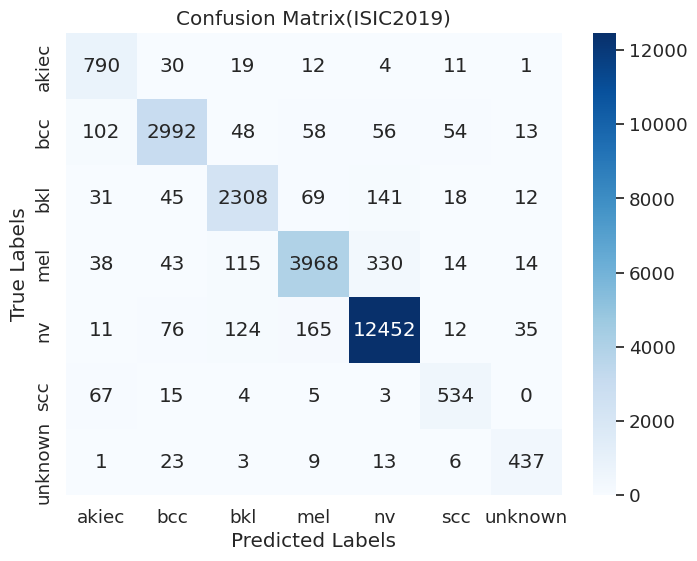


Multiclass Accuracy(ISIC2019): 0.926966957482926
ISIC2019 Multiclass Classification Report():
              precision    recall  f1-score       support
akiec          0.759615  0.911188  0.828526    867.000000
bcc            0.928040  0.900391  0.914006   3323.000000
bkl            0.880580  0.879573  0.880076   2624.000000
mel            0.925805  0.877488  0.900999   4522.000000
nv             0.957920  0.967146  0.962511  12875.000000
scc            0.822804  0.850318  0.836335    628.000000
unknown        0.853516  0.888211  0.870518    492.000000
accuracy       0.926967  0.926967  0.926967      0.926967
macro avg      0.875469  0.896331  0.884710  25331.000000
weighted avg   0.928091  0.926967  0.927127  25331.000000

Multiclass ROC AUC Score(ISIC2019): 0.940921394058911


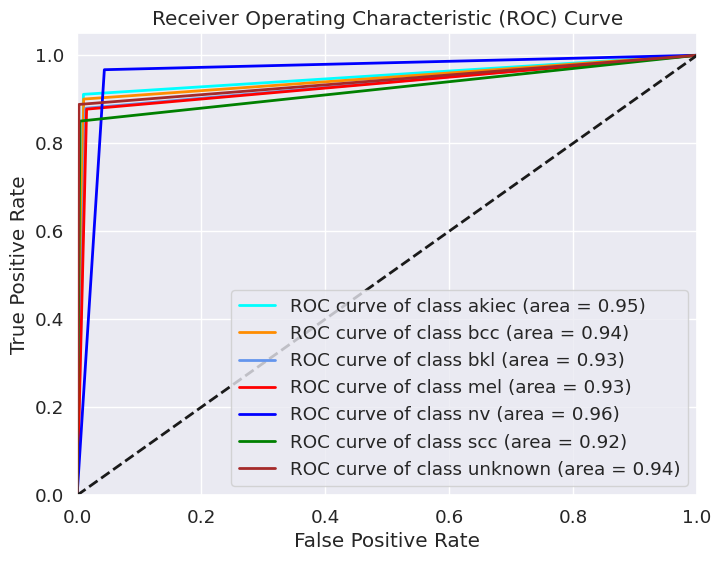

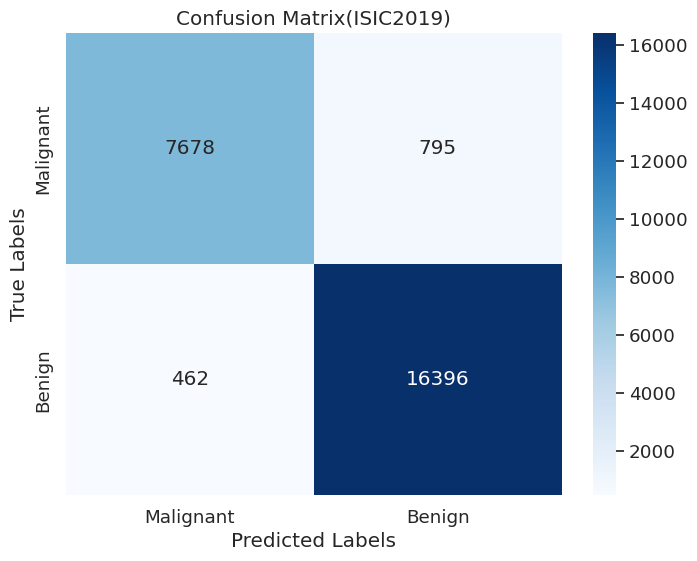


Binary Class Accuracy(ISIC2019): 0.9503770084086692
ISIC2019 Binary class Classification Report:
              precision    recall  f1-score       support
Malignant      0.943243  0.906173  0.924336   8473.000000
Benign         0.953755  0.972595  0.963083  16858.000000
accuracy       0.950377  0.950377  0.950377      0.950377
macro avg      0.948499  0.939384  0.943709  25331.000000
weighted avg   0.950239  0.950377  0.950122  25331.000000

Binary Class ROC AUC Score(ISIC2019): 0.9393835809635701


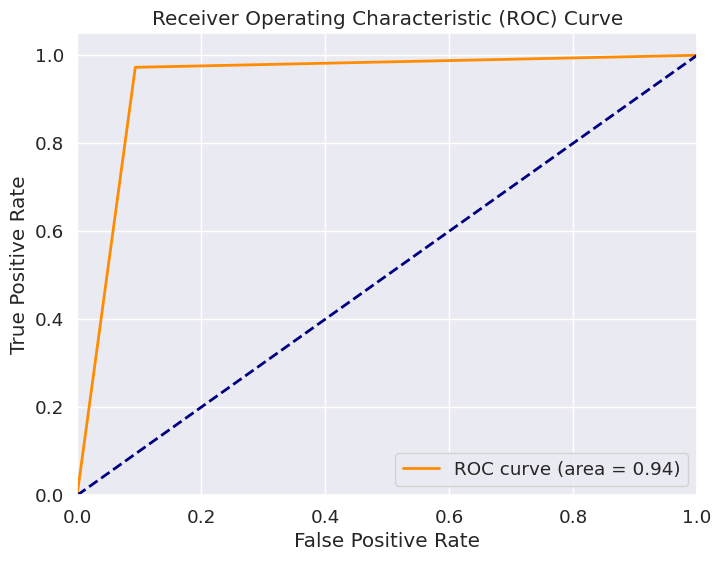

In [5]:
test_dir = '/kaggle/input/test-model-dataset/testing_model/2019'
test_metadata = []
for disease in ['akiec', 'bcc', 'bkl', 'mel', 'nv', 'scc', 'unknown']:
    test_images = os.listdir(os.path.join(test_dir, disease))
    test_metadata.extend([(os.path.join(test_dir, disease, image), disease) for image in test_images])
test_df3 = pd.DataFrame(test_metadata, columns=['image_id', 'dx'])
print("Number of pictures for each class in test folder")
print(test_df3['dx'].value_counts())
test_df3 = test_df3.sample(frac=1).reset_index(drop=True)

del test_metadata

# Now you can transform the labels in your dataframe
test_df3['label'] = le.transform(test_df3['dx'])
test_df3.drop('dx', axis=1, inplace=True)
print(test_df3['label'].value_counts())
images = []

# Iterate over the DataFrame
for idx, row in test_df3.iterrows():
    # Open, resize and convert the image to a numpy array
    image = np.asarray(Image.open(row['image_id']).resize((SIZE, SIZE)))
    # Append the image to the list
    images.append(image)
# Drop the 'image_id' column from the DataFrame
test_df3.drop('image_id', axis=1, inplace=True)

# Add the list of images as a new column in the DataFrame
test_df3['image'] = images

x_test = np.asarray(test_df3['image'].tolist())
# x_test = x_test/255.
Y=test_df3['label']
y_test = to_categorical(Y, num_classes=7)
y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Convert one-hot encoded actual classes to class labels
y_true_labels = np.argmax(y_test, axis=1)
# Convert class indices to class names for y_true and y_pred
y_true_labels_names = [label_to_dx_mapping[label] for label in y_true_labels]
y_pred_labels_names = [label_to_dx_mapping[label] for label in y_pred_labels]
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_labels_names, y_pred_labels_names)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(label_to_dx_mapping.values()),
            yticklabels=list(label_to_dx_mapping.values()))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix(ISIC2019)')
plt.show()

# Calculate accuracy
accuracy = np.mean(y_pred_labels == y_true_labels)
print("\nMulticlass Accuracy(ISIC2019):", accuracy)
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

report = classification_report(y_true_labels_names, y_pred_labels_names, output_dict=True)
report_df = pd.DataFrame(report).transpose()

lb = LabelBinarizer()

lb.fit(y_true_labels_names)
y_test_bin = lb.transform(y_true_labels_names)
y_pred_bin = lb.transform(y_pred_labels_names)

roc_auc = roc_auc_score(y_test_bin, y_pred_bin, multi_class='ovr')

print("ISIC2019 Multiclass Classification Report():")
print(report_df)

print("\nMulticlass ROC AUC Score(ISIC2019):", roc_auc)
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle

# Binarize the output
y_test_bin = label_binarize(y_true_labels, classes=[0, 1, 2, 3, 4, 5, 6])
n_classes = y_test_bin.shape[1] 

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):  # This will iterate over indices 0-5
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Plot all ROC curves

plt.figure(figsize=(8, 6))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'blue', 'green', 'brown'])
for i, color in zip([0, 1, 2, 3, 4, 5, 6], colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(label_to_dx_mapping[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
# Convert y_pred to the new binary format
y_new = np.zeros((y_pred.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_new[:, 0] = y_pred[:, 1] + y_pred[:, 3] + y_pred[:, 5]
y_new[:, 1] = y_pred[:, 0] + y_pred[:, 2] + y_pred[:, 4] + y_pred[:, 6]

# Convert probabilities to class labels
y_pred_labels = np.argmax(y_new, axis=1)
# Convert one-hot encoded y_test to the new binary format
y_true_new = np.zeros((y_test.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_true_new[:, 0] = y_test[:, 1] + y_test[:, 3] + y_test[:, 5]
y_true_new[:, 1] = y_test[:, 0] + y_test[:, 2] + y_test[:, 4] + y_test[:, 6]

# Convert probabilities to class labels
y_true_labels = np.argmax(y_true_new, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Malignant', 'Benign'],
            yticklabels=['Malignant', 'Benign'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix(ISIC2019)')
plt.show()

# Calculate accuracy
accuracy = np.mean(y_pred_labels == y_true_labels)
print("\nBinary Class Accuracy(ISIC2019):", accuracy)
from sklearn.metrics import classification_report, roc_auc_score

# Calculate Precision, Recall, F1-score, and Support
report = classification_report(y_true_labels, y_pred_labels, target_names=['Malignant', 'Benign'], output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Calculate AUC score
roc_auc = roc_auc_score(y_true_labels, y_pred_labels)

print("ISIC2019 Binary class Classification Report:")
print(report_df)

print("\nBinary Class ROC AUC Score(ISIC2019):", roc_auc)
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_true_labels, y_pred_labels)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

2140/2140 ━━━━━━━━━━━━━━━━━━━━ 47s 22ms/step


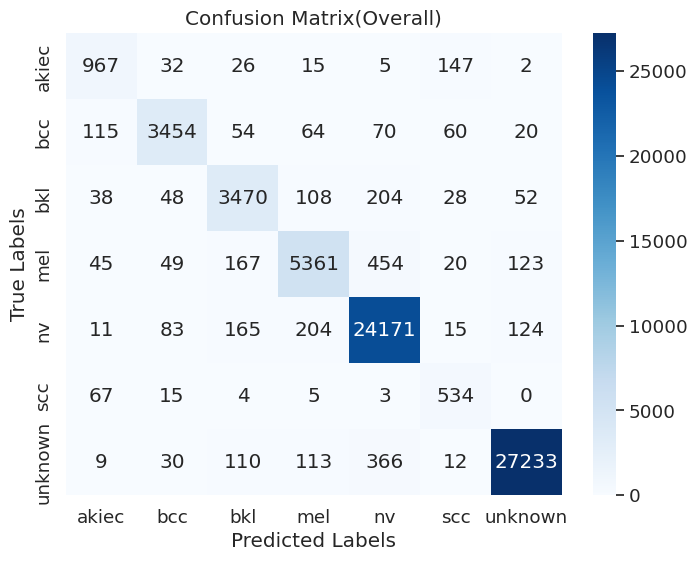


Multiclass Accuracy(Overall): 0.9520679985979671
Overall Multiclass Classification Report():
              precision    recall  f1-score       support
akiec          0.772364  0.809883  0.790679   1194.000000
bcc            0.930746  0.900182  0.915209   3837.000000
bkl            0.868368  0.878926  0.873615   3948.000000
mel            0.913288  0.862036  0.886922   6219.000000
nv             0.956396  0.975699  0.965951  24773.000000
scc            0.654412  0.850318  0.739612    628.000000
unknown        0.988350  0.977039  0.982662  27873.000000
accuracy       0.952068  0.952068  0.952068      0.952068
macro avg      0.869132  0.893440  0.879236  68472.000000
weighted avg   0.952997  0.952068  0.952276  68472.000000

Multiclass ROC AUC Score(Overall): 0.942304402953415


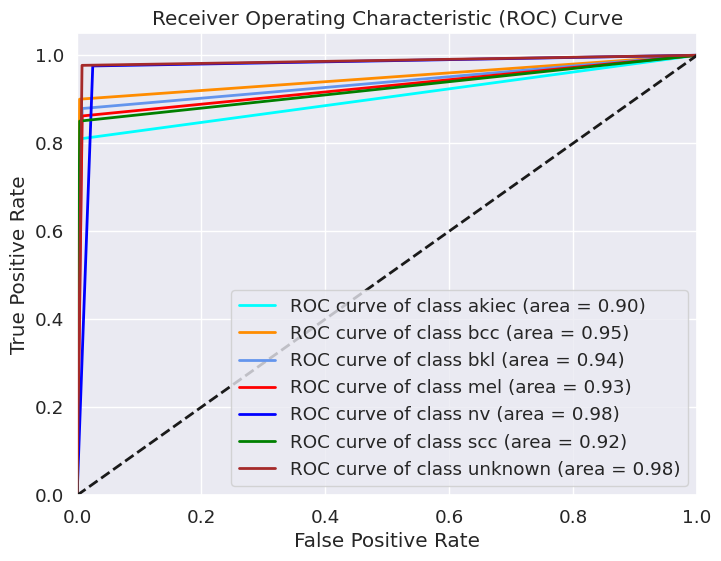

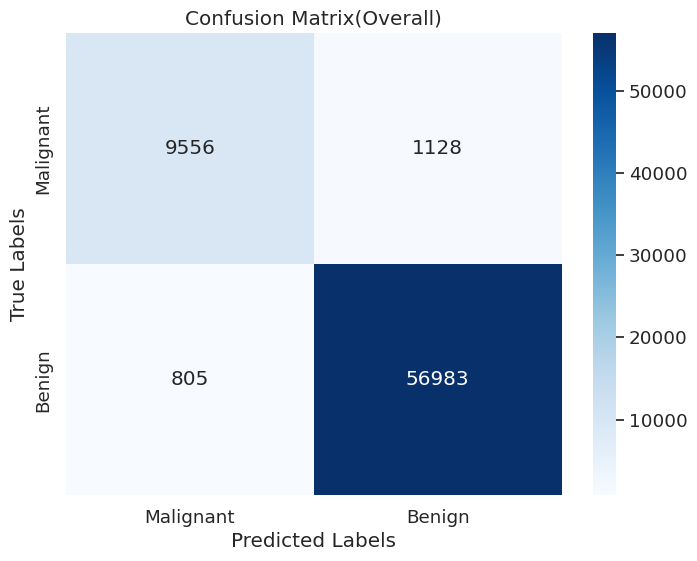


Binary Class Accuracy(Overall): 0.9717694824161701
Overall Binary class Classification Report:
              precision    recall  f1-score       support
Malignant      0.922305  0.894422  0.908149  10684.000000
Benign         0.980589  0.986070  0.983322  57788.000000
accuracy       0.971769  0.971769  0.971769      0.971769
macro avg      0.951447  0.940246  0.945735  68472.000000
weighted avg   0.971495  0.971769  0.971592  68472.000000

Binary Class ROC AUC Score(Overall): 0.9402456686140022


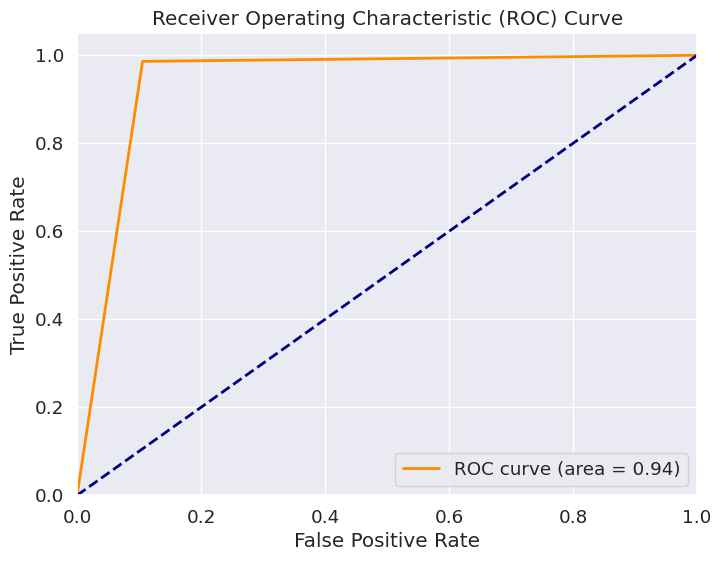

In [6]:
test_df = pd.concat([test_df1, test_df2, test_df3])
x_test = np.asarray(test_df['image'].tolist())
# x_test = x_test/255.
Y=test_df['label']
y_test = to_categorical(Y, num_classes=7)
y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Convert one-hot encoded actual classes to class labels
y_true_labels = np.argmax(y_test, axis=1)
# Convert class indices to class names for y_true and y_pred
y_true_labels_names = [label_to_dx_mapping[label] for label in y_true_labels]
y_pred_labels_names = [label_to_dx_mapping[label] for label in y_pred_labels]
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_labels_names, y_pred_labels_names)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(label_to_dx_mapping.values()),
            yticklabels=list(label_to_dx_mapping.values()))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix(Overall)')
plt.show()

# Calculate accuracy
accuracy = np.mean(y_pred_labels == y_true_labels)
print("\nMulticlass Accuracy(Overall):", accuracy)
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

report = classification_report(y_true_labels_names, y_pred_labels_names, output_dict=True)
report_df = pd.DataFrame(report).transpose()

lb = LabelBinarizer()

lb.fit(y_true_labels_names)
y_test_bin = lb.transform(y_true_labels_names)
y_pred_bin = lb.transform(y_pred_labels_names)

roc_auc = roc_auc_score(y_test_bin, y_pred_bin, multi_class='ovr')

print("Overall Multiclass Classification Report():")
print(report_df)

print("\nMulticlass ROC AUC Score(Overall):", roc_auc)
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle

# Binarize the output
y_test_bin = label_binarize(y_true_labels, classes=[0, 1, 2, 3, 4, 5, 6])
n_classes = y_test_bin.shape[1] 

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):  # This will iterate over indices 0-5
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Plot all ROC curves

plt.figure(figsize=(8, 6))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'blue', 'green', 'brown'])
for i, color in zip([0, 1, 2, 3, 4, 5, 6], colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(label_to_dx_mapping[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
# Convert y_pred to the new binary format
y_new = np.zeros((y_pred.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_new[:, 0] = y_pred[:, 1] + y_pred[:, 3] + y_pred[:, 5]
y_new[:, 1] = y_pred[:, 0] + y_pred[:, 2] + y_pred[:, 4] + y_pred[:, 6]

# Convert probabilities to class labels
y_pred_labels = np.argmax(y_new, axis=1)
# Convert one-hot encoded y_test to the new binary format
y_true_new = np.zeros((y_test.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_true_new[:, 0] = y_test[:, 1] + y_test[:, 3] + y_test[:, 5]
y_true_new[:, 1] = y_test[:, 0] + y_test[:, 2] + y_test[:, 4] + y_test[:, 6]

# Convert probabilities to class labels
y_true_labels = np.argmax(y_true_new, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Malignant', 'Benign'],
            yticklabels=['Malignant', 'Benign'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix(Overall)')
plt.show()

# Calculate accuracy
accuracy = np.mean(y_pred_labels == y_true_labels)
print("\nBinary Class Accuracy(Overall):", accuracy)
from sklearn.metrics import classification_report, roc_auc_score

# Calculate Precision, Recall, F1-score, and Support
report = classification_report(y_true_labels, y_pred_labels, target_names=['Malignant', 'Benign'], output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Calculate AUC score
roc_auc = roc_auc_score(y_true_labels, y_pred_labels)

print("Overall Binary class Classification Report:")
print(report_df)

print("\nBinary Class ROC AUC Score(Overall):", roc_auc)
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_true_labels, y_pred_labels)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Number of pictures for each class in test folder
dx
nv         1340
mel         222
bkl         221
bcc         103
akiec        65
unknown      52
Name: count, dtype: int64
label
4    1340
3     222
2     221
1     103
0      65
6      52
Name: count, dtype: int64
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


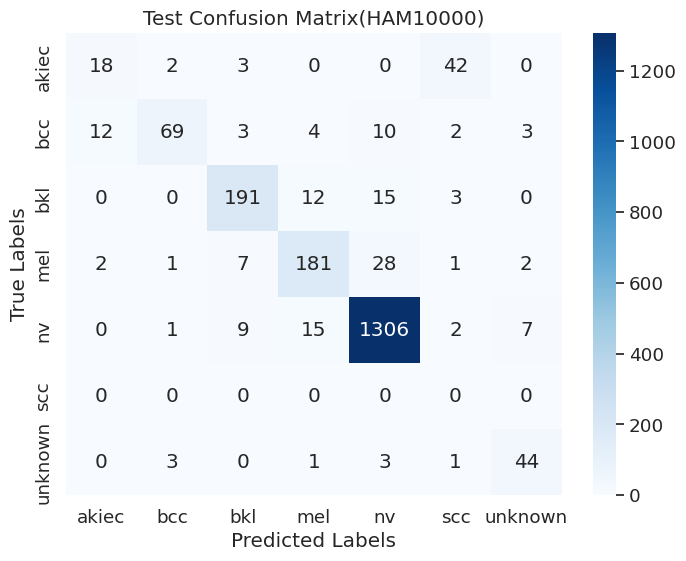


Multiclass Testing Accuracy(HAM10000): 0.9031452820768847
HAM10000 Multiclass Test Classification Report():
              precision    recall  f1-score      support
akiec          0.562500  0.276923  0.371134    65.000000
bcc            0.907895  0.669903  0.770950   103.000000
bkl            0.896714  0.864253  0.880184   221.000000
mel            0.849765  0.815315  0.832184   222.000000
nv             0.958884  0.974627  0.966691  1340.000000
scc            0.000000  0.000000  0.000000     0.000000
unknown        0.785714  0.846154  0.814815    52.000000
accuracy       0.903145  0.903145  0.903145     0.903145
macro avg      0.708782  0.635311  0.662280  2003.000000
weighted avg   0.919950  0.903145  0.908904  2003.000000

Multiclass Testing ROC AUC Score(HAM10000): 0.8596115747976508


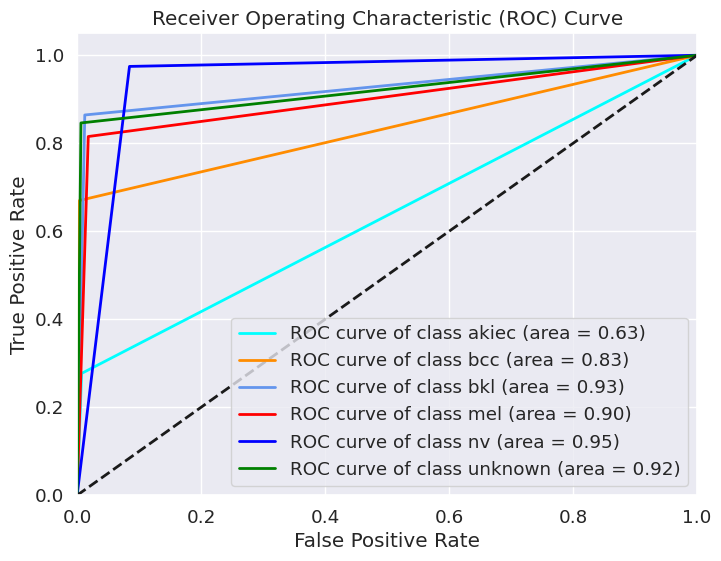

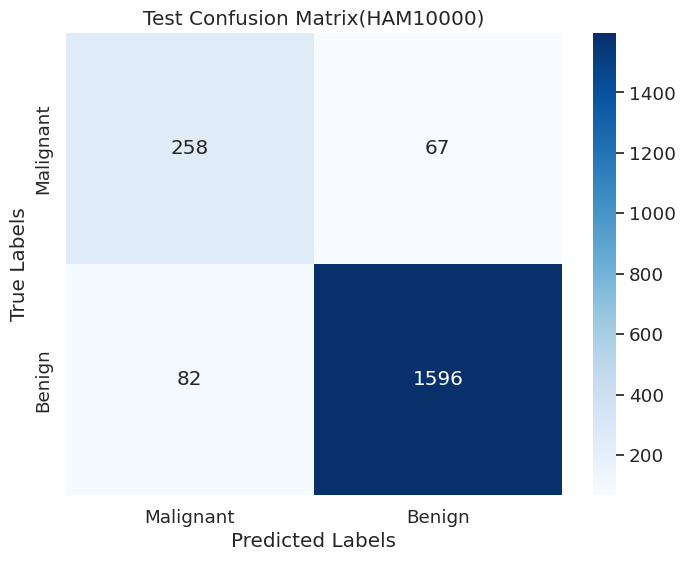


Binary Class Testing Accuracy(HAM10000): 0.9256115826260609
HAM10000 Binary class Testing Classification Report:
              precision    recall  f1-score      support
Malignant      0.758824  0.793846  0.775940   325.000000
Benign         0.959711  0.951132  0.955403  1678.000000
accuracy       0.925612  0.925612  0.925612     0.925612
macro avg      0.859267  0.872489  0.865671  2003.000000
weighted avg   0.927116  0.925612  0.926284  2003.000000

Binary Class ROC AUC Score(HAM10000): 0.8724892271018612


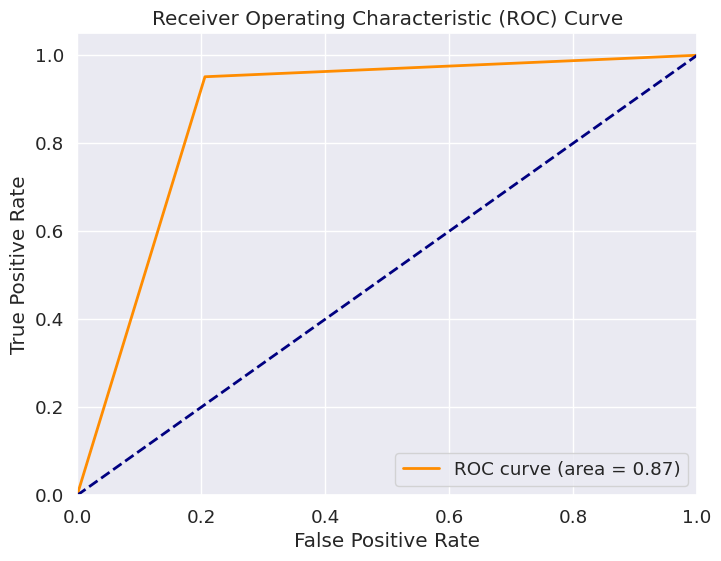

In [7]:
test_dir = '/kaggle/input/hair-removed-knowledge-base/KnowledgeBase/test/ham10000'
test_metadata = []
for disease in ['akiec', 'bcc', 'bkl', 'mel', 'nv', 'unknown']:
    test_images = os.listdir(os.path.join(test_dir, disease))
    test_metadata.extend([(os.path.join(test_dir, disease, image), disease) for image in test_images])
test_df1 = pd.DataFrame(test_metadata, columns=['image_id', 'dx'])
print("Number of pictures for each class in test folder")
print(test_df1['dx'].value_counts())
test_df1 = test_df1.sample(frac=1).reset_index(drop=True)

del test_metadata

# Now you can transform the labels in your dataframe
test_df1['label'] = le.transform(test_df1['dx'])
test_df1.drop('dx', axis=1, inplace=True)
print(test_df1['label'].value_counts())
images = []

# Iterate over the DataFrame
for idx, row in test_df1.iterrows():
    # Open, resize and convert the image to a numpy array
    image = np.asarray(Image.open(row['image_id']).resize((SIZE, SIZE)))
    # Append the image to the list
    images.append(image)
# Drop the 'image_id' column from the DataFrame
test_df1.drop('image_id', axis=1, inplace=True)

# Add the list of images as a new column in the DataFrame
test_df1['image'] = images

x_test = np.asarray(test_df1['image'].tolist())
# x_test = x_test/255.
Y=test_df1['label']
y_test = to_categorical(Y, num_classes=7)
y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Convert one-hot encoded actual classes to class labels
y_true_labels = np.argmax(y_test, axis=1)
# Convert class indices to class names for y_true and y_pred
y_true_labels_names = [label_to_dx_mapping[label] for label in y_true_labels]
y_pred_labels_names = [label_to_dx_mapping[label] for label in y_pred_labels]
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_labels_names, y_pred_labels_names)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(label_to_dx_mapping.values()),
            yticklabels=list(label_to_dx_mapping.values()))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Test Confusion Matrix(HAM10000)')
plt.show()

# Calculate accuracy
accuracy = np.mean(y_pred_labels == y_true_labels)
print("\nMulticlass Testing Accuracy(HAM10000):", accuracy)
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

report = classification_report(y_true_labels_names, y_pred_labels_names, output_dict=True)
report_df = pd.DataFrame(report).transpose()

lb = LabelBinarizer()

lb.fit(y_true_labels_names)
y_test_bin = lb.transform(y_true_labels_names)
y_pred_bin = lb.transform(y_pred_labels_names)

roc_auc = roc_auc_score(y_test_bin, y_pred_bin, multi_class='ovr')

print("HAM10000 Multiclass Test Classification Report():")
print(report_df)

print("\nMulticlass Testing ROC AUC Score(HAM10000):", roc_auc)
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle

# Binarize the output
y_test_bin = label_binarize(y_true_labels, classes=[0, 1, 2, 3, 4, 6])
n_classes = 7

n_classes = y_test_bin.shape[1]  # This will now be 6

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):  # This will iterate over indices 0-5
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Plot all ROC curves

maping = ['akiec', 'bcc', 'bkl', 'mel', 'nv', 'unknown']
plt.figure(figsize=(8, 6))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'blue', 'green', 'brown'])
for i, color in zip([0, 1, 2, 3, 4, 5], colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(maping[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
# Convert y_pred to the new binary format
y_new = np.zeros((y_pred.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_new[:, 0] = y_pred[:, 1] + y_pred[:, 3] + y_pred[:, 5]
y_new[:, 1] = y_pred[:, 0] + y_pred[:, 2] + y_pred[:, 4] + y_pred[:, 6]

# Convert probabilities to class labels
y_pred_labels = np.argmax(y_new, axis=1)
# Convert one-hot encoded y_test to the new binary format
y_true_new = np.zeros((y_test.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_true_new[:, 0] = y_test[:, 1] + y_test[:, 3] + y_test[:, 5]
y_true_new[:, 1] = y_test[:, 0] + y_test[:, 2] + y_test[:, 4] + y_test[:, 6]

# Convert probabilities to class labels
y_true_labels = np.argmax(y_true_new, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Malignant', 'Benign'],
            yticklabels=['Malignant', 'Benign'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Test Confusion Matrix(HAM10000)')
plt.show()

# Calculate accuracy
accuracy = np.mean(y_pred_labels == y_true_labels)
print("\nBinary Class Testing Accuracy(HAM10000):", accuracy)
from sklearn.metrics import classification_report, roc_auc_score

# Calculate Precision, Recall, F1-score, and Support
report = classification_report(y_true_labels, y_pred_labels, target_names=['Malignant', 'Benign'], output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Calculate AUC score
roc_auc = roc_auc_score(y_true_labels, y_pred_labels)

print("HAM10000 Binary class Testing Classification Report:")
print(report_df)

print("\nBinary Class ROC AUC Score(HAM10000):", roc_auc)
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_true_labels, y_pred_labels)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Number of pictures for each class in test folder
dx
unknown    5447
nv         1030
mel         105
bkl          44
Name: count, dtype: int64
label
6    5447
4    1030
3     105
2      44
Name: count, dtype: int64
208/208 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step


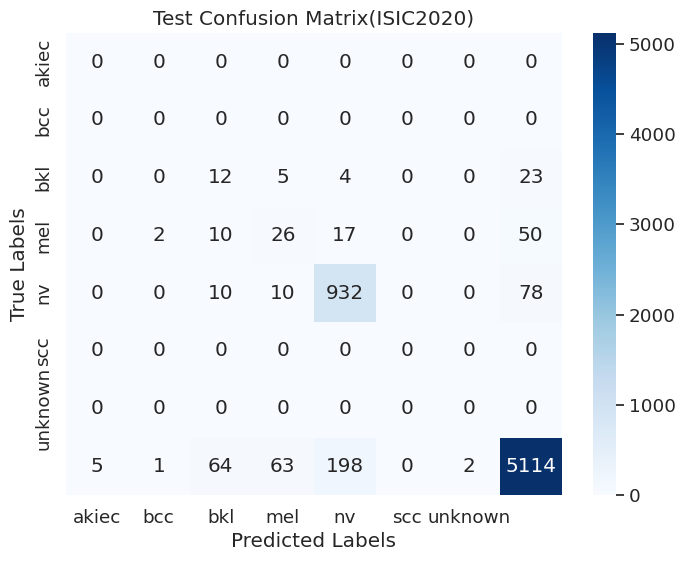


Multiclass Testing Accuracy(ISIC2020): 0.9182010262601872
ISIC2020 Multiclass Test Classification Report():
              precision    recall  f1-score      support
akiec          0.000000  0.000000  0.000000     0.000000
bcc            0.000000  0.000000  0.000000     0.000000
bkl            0.125000  0.272727  0.171429    44.000000
mel            0.250000  0.247619  0.248804   105.000000
nv             0.809731  0.904854  0.854654  1030.000000
scc            0.000000  0.000000  0.000000     0.000000
unknown        0.971320  0.938865  0.954817  5447.000000
accuracy       0.918201  0.918201  0.918201     0.918201
macro avg      0.308007  0.337724  0.318529  6626.000000
weighted avg   0.929151  0.918201  0.922857  6626.000000

Multiclass Testing ROC AUC Score(ISIC2020): 0.771516618719015


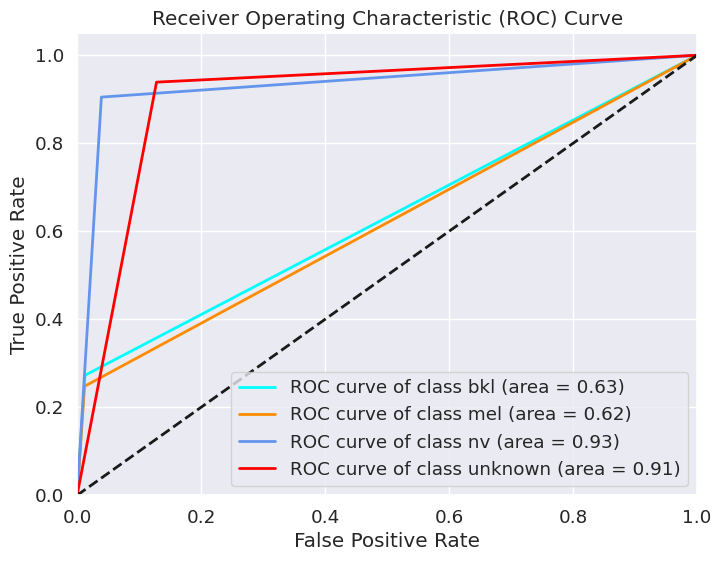

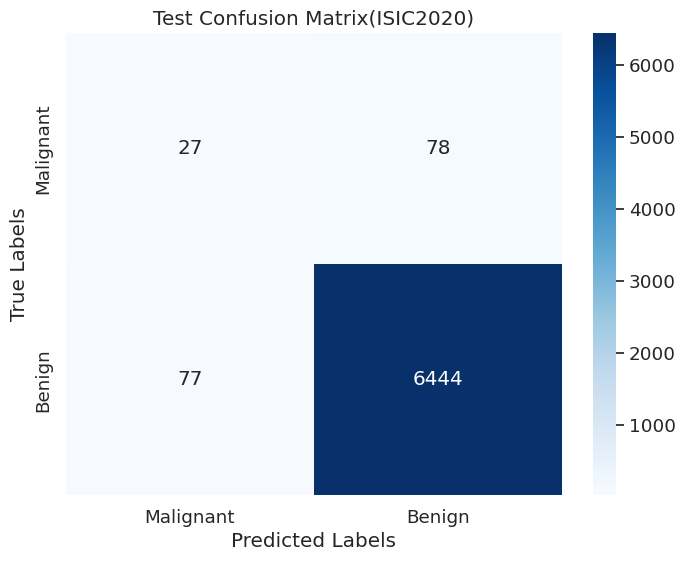


Binary Class Testing Accuracy(ISIC2020): 0.9766073045578026
ISIC2020 Binary class Testing Classification Report:
              precision    recall  f1-score      support
Malignant      0.259615  0.257143  0.258373   105.000000
Benign         0.988040  0.988192  0.988116  6521.000000
accuracy       0.976607  0.976607  0.976607     0.976607
macro avg      0.623828  0.622667  0.623245  6626.000000
weighted avg   0.976497  0.976607  0.976552  6626.000000

Binary Class ROC AUC Score(ISIC2020): 0.6226674261178171


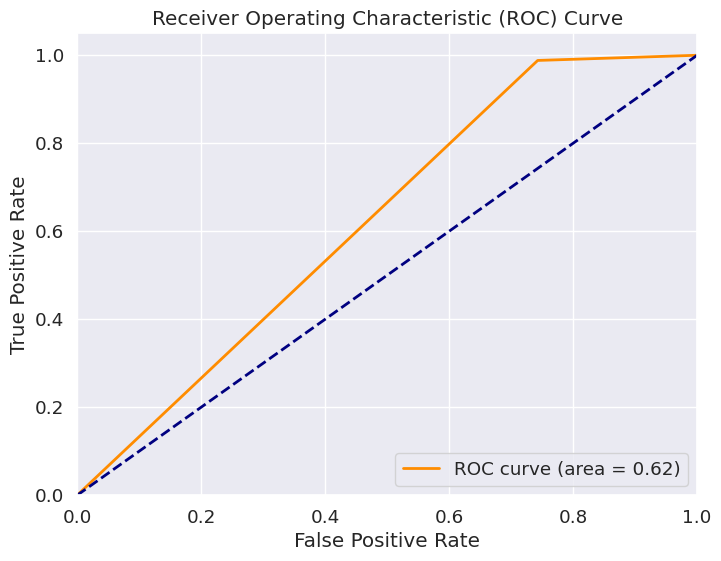

In [8]:
test_dir = '/kaggle/input/hair-removed-knowledge-base/KnowledgeBase/test/2020'
test_metadata = []
for disease in ['bkl', 'mel', 'nv', 'unknown']:
    test_images = os.listdir(os.path.join(test_dir, disease))
    test_metadata.extend([(os.path.join(test_dir, disease, image), disease) for image in test_images])
test_df2 = pd.DataFrame(test_metadata, columns=['image_id', 'dx'])
print("Number of pictures for each class in test folder")
print(test_df2['dx'].value_counts())
test_df2 = test_df2.sample(frac=1).reset_index(drop=True)

del test_metadata

# Now you can transform the labels in your dataframe
test_df2['label'] = le.transform(test_df2['dx'])
test_df2.drop('dx', axis=1, inplace=True)
print(test_df2['label'].value_counts())
images = []

# Iterate over the DataFrame
for idx, row in test_df2.iterrows():
    # Open, resize and convert the image to a numpy array
    image = np.asarray(Image.open(row['image_id']).resize((SIZE, SIZE)))
    # Append the image to the list
    images.append(image)
# Drop the 'image_id' column from the DataFrame
test_df2.drop('image_id', axis=1, inplace=True)

# Add the list of images as a new column in the DataFrame
test_df2['image'] = images

x_test = np.asarray(test_df2['image'].tolist())
# x_test = x_test/255.
Y=test_df2['label']
y_test = to_categorical(Y, num_classes=7)
y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Convert one-hot encoded actual classes to class labels
y_true_labels = np.argmax(y_test, axis=1)
# Convert class indices to class names for y_true and y_pred
y_true_labels_names = [label_to_dx_mapping[label] for label in y_true_labels]
y_pred_labels_names = [label_to_dx_mapping[label] for label in y_pred_labels]
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_labels_names, y_pred_labels_names)

# The row you want to insert should have the same number of elements as there are columns in conf_matrix
new_row = np.zeros(conf_matrix.shape[1])

# Insert the new row at index 5
conf_matrix = np.insert(conf_matrix, 5, new_row, axis=0)
conf_matrix = np.insert(conf_matrix, 5, 0, axis=1)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(label_to_dx_mapping.values()),
            yticklabels=list(label_to_dx_mapping.values()))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Test Confusion Matrix(ISIC2020)')
plt.show()

# Calculate accuracy
accuracy = np.mean(y_pred_labels == y_true_labels)
print("\nMulticlass Testing Accuracy(ISIC2020):", accuracy)
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

report = classification_report(y_true_labels_names, y_pred_labels_names, output_dict=True)
report_df = pd.DataFrame(report).transpose()

lb = LabelBinarizer()

lb.fit(y_true_labels_names)
y_test_bin = lb.transform(y_true_labels_names)
y_pred_bin = lb.transform(y_pred_labels_names)

roc_auc = roc_auc_score(y_test_bin, y_pred_bin, multi_class='ovr')

print("ISIC2020 Multiclass Test Classification Report():")
print(report_df)

print("\nMulticlass Testing ROC AUC Score(ISIC2020):", roc_auc)
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle

# Binarize the output
y_test_bin = label_binarize(y_true_labels, classes=[2, 3, 4, 6])
n_classes = y_test_bin.shape[1] 

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):  # This will iterate over indices 0-5
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Plot all ROC curves

maping = ['bkl', 'mel', 'nv', 'unknown']
plt.figure(figsize=(8, 6))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'blue', 'green', 'brown'])
for i, color in zip([0, 1, 2, 3], colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(maping[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
# Convert y_pred to the new binary format
y_new = np.zeros((y_pred.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_new[:, 0] = y_pred[:, 1] + y_pred[:, 3] + y_pred[:, 5]
y_new[:, 1] = y_pred[:, 0] + y_pred[:, 2] + y_pred[:, 4] + y_pred[:, 6]

# Convert probabilities to class labels
y_pred_labels = np.argmax(y_new, axis=1)
# Convert one-hot encoded y_test to the new binary format
y_true_new = np.zeros((y_test.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_true_new[:, 0] = y_test[:, 1] + y_test[:, 3] + y_test[:, 5]
y_true_new[:, 1] = y_test[:, 0] + y_test[:, 2] + y_test[:, 4] + y_test[:, 6]

# Convert probabilities to class labels
y_true_labels = np.argmax(y_true_new, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Malignant', 'Benign'],
            yticklabels=['Malignant', 'Benign'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Test Confusion Matrix(ISIC2020)')
plt.show()

# Calculate accuracy
accuracy = np.mean(y_pred_labels == y_true_labels)
print("\nBinary Class Testing Accuracy(ISIC2020):", accuracy)
from sklearn.metrics import classification_report, roc_auc_score

# Calculate Precision, Recall, F1-score, and Support
report = classification_report(y_true_labels, y_pred_labels, target_names=['Malignant', 'Benign'], output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Calculate AUC score
roc_auc = roc_auc_score(y_true_labels, y_pred_labels)

print("ISIC2020 Binary class Testing Classification Report:")
print(report_df)

print("\nBinary Class ROC AUC Score(ISIC2020):", roc_auc)
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_true_labels, y_pred_labels)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Number of pictures for each class in test folder
dx
nv         2622
mel         857
bcc         695
bkl         508
akiec       164
scc         128
unknown      93
Name: count, dtype: int64
label
4    2622
3     857
1     695
2     508
0     164
5     128
6      93
Name: count, dtype: int64
159/159 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step


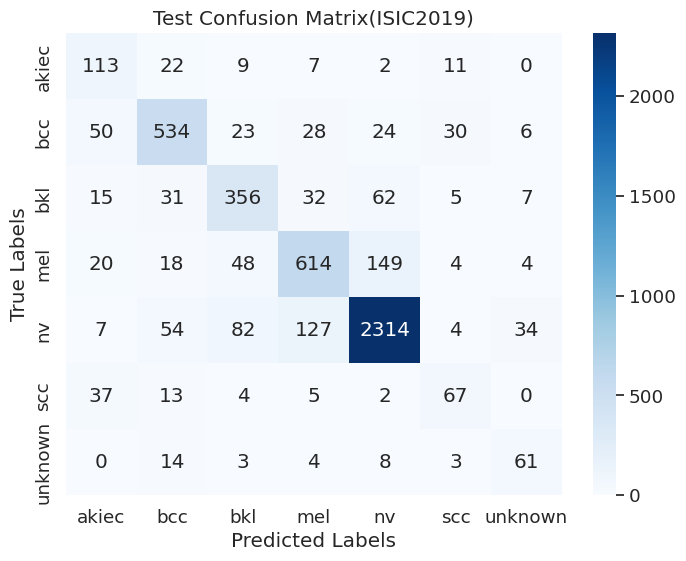


Multiclass Testing Accuracy(ISIC2019): 0.8010657193605684
ISIC2019 Multiclass Test Classification Report():
              precision    recall  f1-score      support
akiec          0.466942  0.689024  0.556650   164.000000
bcc            0.778426  0.768345  0.773353   695.000000
bkl            0.678095  0.700787  0.689255   508.000000
mel            0.751530  0.716453  0.733572   857.000000
nv             0.903553  0.882532  0.892919  2622.000000
scc            0.540323  0.523438  0.531746   128.000000
unknown        0.544643  0.655914  0.595122    93.000000
accuracy       0.801066  0.801066  0.801066     0.801066
macro avg      0.666216  0.705213  0.681802  5067.000000
weighted avg   0.808180  0.801066  0.803676  5067.000000

Multiclass Testing ROC AUC Score(ISIC2019): 0.8333794260605379


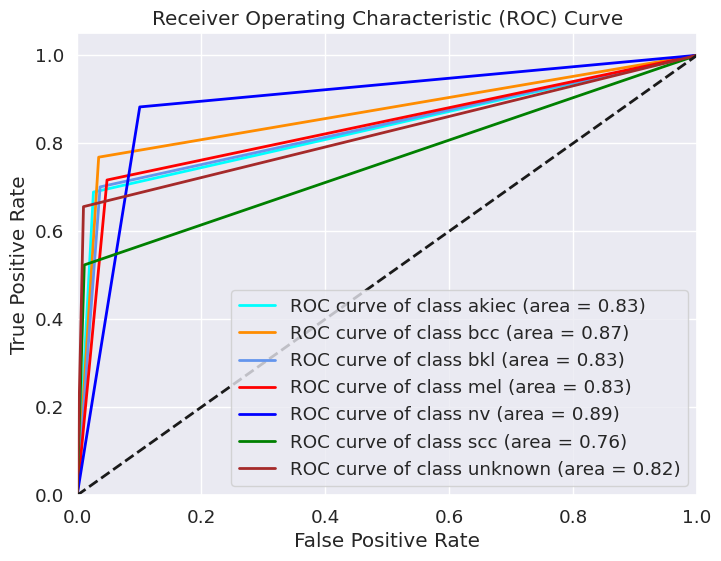

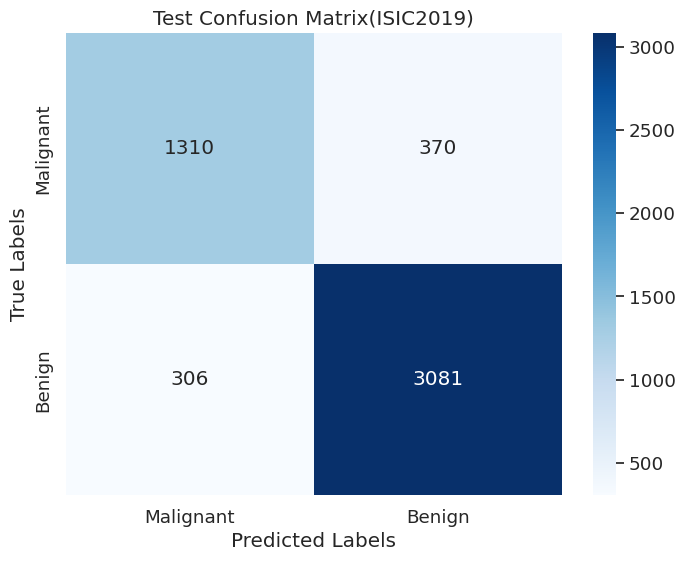


Binary Class Testing Accuracy(ISIC2019): 0.8665877244918098
ISIC2019 Binary class Testing Classification Report:
              precision    recall  f1-score      support
Malignant      0.810644  0.779762  0.794903  1680.000000
Benign         0.892785  0.909655  0.901141  3387.000000
accuracy       0.866588  0.866588  0.866588     0.866588
macro avg      0.851714  0.844708  0.848022  5067.000000
weighted avg   0.865550  0.866588  0.865917  5067.000000

Binary Class ROC AUC Score(ISIC2019): 0.8447082331604033


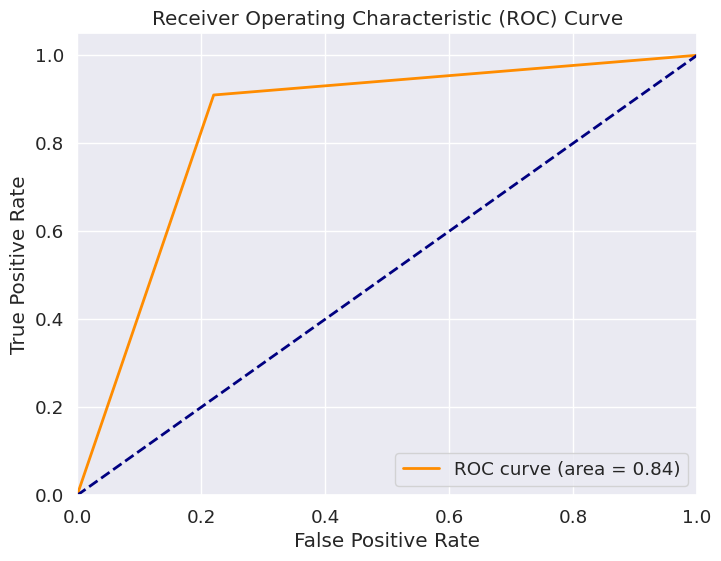

In [9]:
test_dir = '/kaggle/input/hair-removed-knowledge-base/KnowledgeBase/test/2019'
test_metadata = []
for disease in ['akiec', 'bcc', 'bkl', 'mel', 'nv', 'scc', 'unknown']:
    test_images = os.listdir(os.path.join(test_dir, disease))
    test_metadata.extend([(os.path.join(test_dir, disease, image), disease) for image in test_images])
test_df3 = pd.DataFrame(test_metadata, columns=['image_id', 'dx'])
print("Number of pictures for each class in test folder")
print(test_df3['dx'].value_counts())
test_df3 = test_df3.sample(frac=1).reset_index(drop=True)

del test_metadata

# Now you can transform the labels in your dataframe
test_df3['label'] = le.transform(test_df3['dx'])
test_df3.drop('dx', axis=1, inplace=True)
print(test_df3['label'].value_counts())
images = []

# Iterate over the DataFrame
for idx, row in test_df3.iterrows():
    # Open, resize and convert the image to a numpy array
    image = np.asarray(Image.open(row['image_id']).resize((SIZE, SIZE)))
    # Append the image to the list
    images.append(image)
# Drop the 'image_id' column from the DataFrame
test_df3.drop('image_id', axis=1, inplace=True)

# Add the list of images as a new column in the DataFrame
test_df3['image'] = images

x_test = np.asarray(test_df3['image'].tolist())
# x_test = x_test/255.
Y=test_df3['label']
y_test = to_categorical(Y, num_classes=7)
y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Convert one-hot encoded actual classes to class labels
y_true_labels = np.argmax(y_test, axis=1)
# Convert class indices to class names for y_true and y_pred
y_true_labels_names = [label_to_dx_mapping[label] for label in y_true_labels]
y_pred_labels_names = [label_to_dx_mapping[label] for label in y_pred_labels]
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_labels_names, y_pred_labels_names)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(label_to_dx_mapping.values()),
            yticklabels=list(label_to_dx_mapping.values()))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Test Confusion Matrix(ISIC2019)')
plt.show()

# Calculate accuracy
accuracy = np.mean(y_pred_labels == y_true_labels)
print("\nMulticlass Testing Accuracy(ISIC2019):", accuracy)
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

report = classification_report(y_true_labels_names, y_pred_labels_names, output_dict=True)
report_df = pd.DataFrame(report).transpose()

lb = LabelBinarizer()

lb.fit(y_true_labels_names)
y_test_bin = lb.transform(y_true_labels_names)
y_pred_bin = lb.transform(y_pred_labels_names)

roc_auc = roc_auc_score(y_test_bin, y_pred_bin, multi_class='ovr')

print("ISIC2019 Multiclass Test Classification Report():")
print(report_df)

print("\nMulticlass Testing ROC AUC Score(ISIC2019):", roc_auc)
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle

# Binarize the output
y_test_bin = label_binarize(y_true_labels, classes=[0, 1, 2, 3, 4, 5, 6])
n_classes = y_test_bin.shape[1] 

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):  # This will iterate over indices 0-5
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Plot all ROC curves

plt.figure(figsize=(8, 6))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'blue', 'green', 'brown'])
for i, color in zip([0, 1, 2, 3, 4, 5, 6], colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(label_to_dx_mapping[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
# Convert y_pred to the new binary format
y_new = np.zeros((y_pred.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_new[:, 0] = y_pred[:, 1] + y_pred[:, 3] + y_pred[:, 5]
y_new[:, 1] = y_pred[:, 0] + y_pred[:, 2] + y_pred[:, 4] + y_pred[:, 6]

# Convert probabilities to class labels
y_pred_labels = np.argmax(y_new, axis=1)
# Convert one-hot encoded y_test to the new binary format
y_true_new = np.zeros((y_test.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_true_new[:, 0] = y_test[:, 1] + y_test[:, 3] + y_test[:, 5]
y_true_new[:, 1] = y_test[:, 0] + y_test[:, 2] + y_test[:, 4] + y_test[:, 6]

# Convert probabilities to class labels
y_true_labels = np.argmax(y_true_new, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Malignant', 'Benign'],
            yticklabels=['Malignant', 'Benign'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Test Confusion Matrix(ISIC2019)')
plt.show()

# Calculate accuracy
accuracy = np.mean(y_pred_labels == y_true_labels)
print("\nBinary Class Testing Accuracy(ISIC2019):", accuracy)
from sklearn.metrics import classification_report, roc_auc_score

# Calculate Precision, Recall, F1-score, and Support
report = classification_report(y_true_labels, y_pred_labels, target_names=['Malignant', 'Benign'], output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Calculate AUC score
roc_auc = roc_auc_score(y_true_labels, y_pred_labels)

print("ISIC2019 Binary class Testing Classification Report:")
print(report_df)

print("\nBinary Class ROC AUC Score(ISIC2019):", roc_auc)
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_true_labels, y_pred_labels)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

428/428 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step


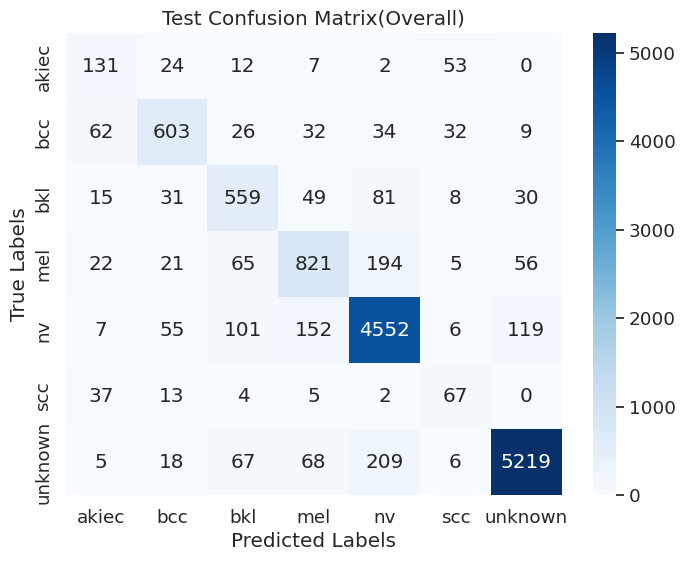


Multiclass Testing Accuracy(Overall): 0.8726635514018691
Overall Multiclass Test Classification Report():
              precision    recall  f1-score       support
akiec          0.469534  0.572052  0.515748    229.000000
bcc            0.788235  0.755639  0.771593    798.000000
bkl            0.670264  0.723157  0.695706    773.000000
mel            0.723986  0.693412  0.708369   1184.000000
nv             0.897123  0.911859  0.904431   4992.000000
scc            0.378531  0.523438  0.439344    128.000000
unknown        0.960611  0.933298  0.946757   5592.000000
accuracy       0.872664  0.872664  0.872664      0.872664
macro avg      0.698326  0.730408  0.711707  13696.000000
weighted avg   0.876933  0.872664  0.874398  13696.000000

Multiclass Testing ROC AUC Score(Overall): 0.853465857098847


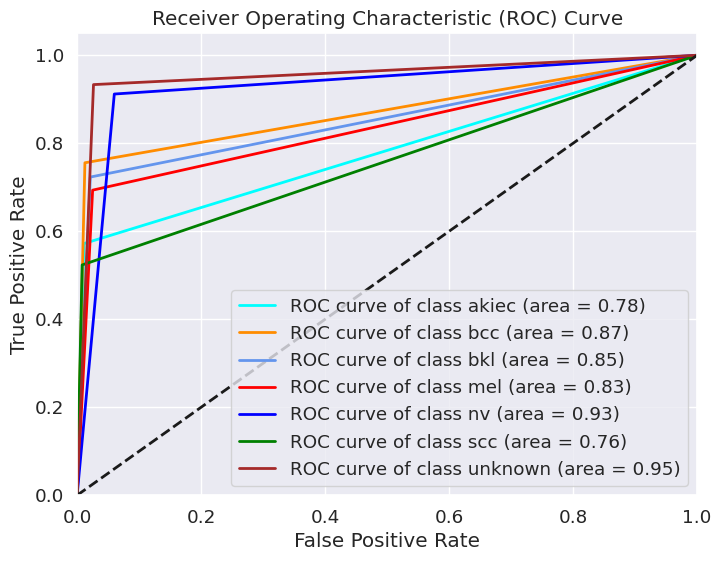

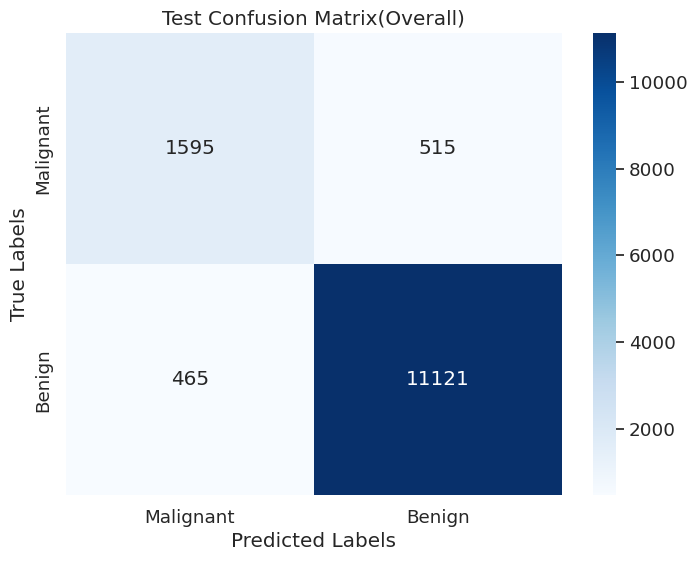


Binary Class Testing Accuracy(Overall): 0.928446261682243
Overall Binary class Testing Classification Report:
              precision    recall  f1-score       support
Malignant      0.774272  0.755924  0.764988   2110.000000
Benign         0.955741  0.959865  0.957799  11586.000000
accuracy       0.928446  0.928446  0.928446      0.928446
macro avg      0.865006  0.857895  0.861393  13696.000000
weighted avg   0.927784  0.928446  0.928094  13696.000000

Binary Class ROC AUC Score(Overall): 0.8578947626772956


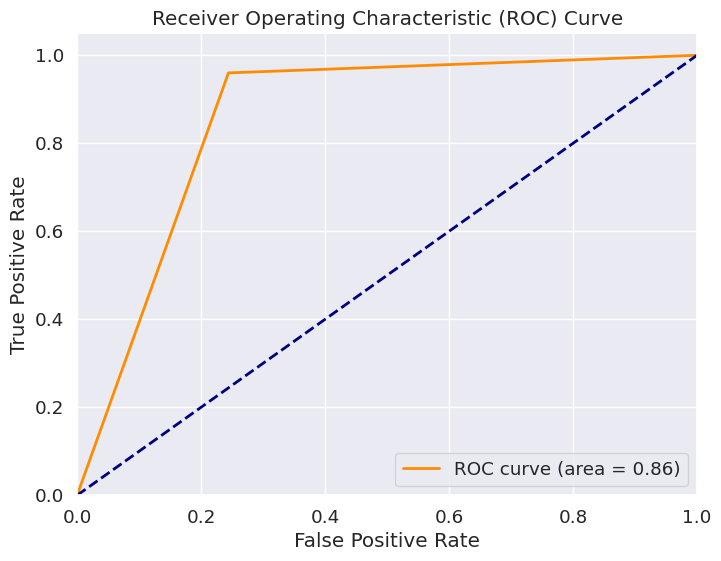

In [10]:
test_df = pd.concat([test_df1, test_df2, test_df3])
x_test = np.asarray(test_df['image'].tolist())
# x_test = x_test/255.
Y=test_df['label']
y_test = to_categorical(Y, num_classes=7)
y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Convert one-hot encoded actual classes to class labels
y_true_labels = np.argmax(y_test, axis=1)
# Convert class indices to class names for y_true and y_pred
y_true_labels_names = [label_to_dx_mapping[label] for label in y_true_labels]
y_pred_labels_names = [label_to_dx_mapping[label] for label in y_pred_labels]
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_labels_names, y_pred_labels_names)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(label_to_dx_mapping.values()),
            yticklabels=list(label_to_dx_mapping.values()))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Test Confusion Matrix(Overall)')
plt.show()

# Calculate accuracy
accuracy = np.mean(y_pred_labels == y_true_labels)
print("\nMulticlass Testing Accuracy(Overall):", accuracy)
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

report = classification_report(y_true_labels_names, y_pred_labels_names, output_dict=True)
report_df = pd.DataFrame(report).transpose()

lb = LabelBinarizer()

lb.fit(y_true_labels_names)
y_test_bin = lb.transform(y_true_labels_names)
y_pred_bin = lb.transform(y_pred_labels_names)

roc_auc = roc_auc_score(y_test_bin, y_pred_bin, multi_class='ovr')

print("Overall Multiclass Test Classification Report():")
print(report_df)

print("\nMulticlass Testing ROC AUC Score(Overall):", roc_auc)
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle

# Binarize the output
y_test_bin = label_binarize(y_true_labels, classes=[0, 1, 2, 3, 4, 5, 6])
n_classes = y_test_bin.shape[1] 

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):  # This will iterate over indices 0-5
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Plot all ROC curves

plt.figure(figsize=(8, 6))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'blue', 'green', 'brown'])
for i, color in zip([0, 1, 2, 3, 4, 5, 6], colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(label_to_dx_mapping[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
# Convert y_pred to the new binary format
y_new = np.zeros((y_pred.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_new[:, 0] = y_pred[:, 1] + y_pred[:, 3] + y_pred[:, 5]
y_new[:, 1] = y_pred[:, 0] + y_pred[:, 2] + y_pred[:, 4] + y_pred[:, 6]

# Convert probabilities to class labels
y_pred_labels = np.argmax(y_new, axis=1)
# Convert one-hot encoded y_test to the new binary format
y_true_new = np.zeros((y_test.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_true_new[:, 0] = y_test[:, 1] + y_test[:, 3] + y_test[:, 5]
y_true_new[:, 1] = y_test[:, 0] + y_test[:, 2] + y_test[:, 4] + y_test[:, 6]

# Convert probabilities to class labels
y_true_labels = np.argmax(y_true_new, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Malignant', 'Benign'],
            yticklabels=['Malignant', 'Benign'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Test Confusion Matrix(Overall)')
plt.show()

# Calculate accuracy
accuracy = np.mean(y_pred_labels == y_true_labels)
print("\nBinary Class Testing Accuracy(Overall):", accuracy)
from sklearn.metrics import classification_report, roc_auc_score

# Calculate Precision, Recall, F1-score, and Support
report = classification_report(y_true_labels, y_pred_labels, target_names=['Malignant', 'Benign'], output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Calculate AUC score
roc_auc = roc_auc_score(y_true_labels, y_pred_labels)

print("Overall Binary class Testing Classification Report:")
print(report_df)

print("\nBinary Class ROC AUC Score(Overall):", roc_auc)
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_true_labels, y_pred_labels)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()